__Homework 4 Companion Notebook__

Here you will find the various functions and skeleton code for use in completing HW4. Take care to carefully read and understand the provided code before use.



__Hierarchical Regression__

This is an example that shows how to build a hierarchical model. These examples are adapted from https://pymc3.readthedocs.io/en/latest/notebooks/multilevel_modeling.html

In [7]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

from pymc3 import get_data

# Import radon data (Preprocessing specific to this dataset.)
srrs2 = pd.read_csv(get_data('srrs2.dat'))
srrs2.columns = srrs2.columns.map(str.strip)
srrs_mn = srrs2[srrs2.state=='MN'].copy()
srrs_mn['fips'] = srrs_mn.stfips*1000 + srrs_mn.cntyfips
cty = pd.read_csv(get_data('cty.dat'))
cty_mn = cty[cty.st=='MN'].copy()
cty_mn[ 'fips'] = 1000*cty_mn.stfips + cty_mn.ctfips
srrs_mn = srrs_mn.merge(cty_mn[['fips', 'Uppm']], on='fips')
srrs_mn = srrs_mn.drop_duplicates(subset='idnum')
u = np.log(srrs_mn.Uppm)
n = len(srrs_mn)
srrs_mn.county = srrs_mn.county.map(str.strip)
mn_counties = srrs_mn.county.unique()
counties = len(mn_counties)
county_lookup = dict(zip(mn_counties, range(len(mn_counties))))
county = srrs_mn['county_code'] = srrs_mn.county.replace(county_lookup).values
radon = srrs_mn.activity
srrs_mn['log_radon'] = log_radon = np.log(radon + 0.1).values
floor_measure = srrs_mn.floor.values

85

In [28]:
with Model() as hierarchical_model:
    # Priors for the fixed effects
    # a - overall intercept, level of radon at mean levels of uranium and no basement
    mu_a = Normal('mu_a', mu=0., sd=1e5)
    sigma_a = HalfCauchy('sigma_a', 5)
    
    #b - overall effect of having a basement
    mu_b = Normal('mu_b', mu=0., sd=1e5)
    sigma_b = HalfCauchy('sigma_b', 5)
    
    #c - overall effect of uranium
    mu_c = Normal('mu_c', mu=0., sd=1e5)
    sigma_c = HalfCauchy('sigma_c', 5)
    
    # Random intercepts as offsets
    a_offset = Normal('a_offset', mu=0, sd=1, shape=counties)
    a = Deterministic("a", mu_a + a_offset * sigma_a)
    
    # County level effect of basement as offset
    b_offset = Normal('b_offset', mu=0, sd=1, shape=counties)
    b = Deterministic("b", mu_b + b_offset * sigma_b)
    
    # County level effect of uranium as offset
    c_offset = Normal('c_offset', mu=0, sd=1, shape=counties)
    c = Deterministic("c", mu_c + c_offset * sigma_c)
    
    # Residual Error
    sigma_y = HalfCauchy('sigma_y', 5)

    # This is the specification for the regression equation itself.
    y_hat = a[county] + b[county]*floor_measure + c[county]*u

    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sd=sigma_y, observed=log_radon)

In [29]:
with hierarchical_model:
    hierarchical_trace = sample(1000, n_init=50000, tune=1000)

<ipython-input-29-85361740bf38>:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  hierarchical_trace = sample(1000, n_init=50000, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_y, c_offset, b_offset, a_offset, sigma_c, mu_c, sigma_b, mu_b, sigma_a, mu_a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 105 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7111484376961587, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


D:\Anaconda\envs\mypm3env\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'mu_a'}>,
        <AxesSubplot:title={'center':'mu_a'}>],
       [<AxesSubplot:title={'center':'mu_b'}>,
        <AxesSubplot:title={'center':'mu_b'}>],
       [<AxesSubplot:title={'center':'mu_c'}>,
        <AxesSubplot:title={'center':'mu_c'}>],
       [<AxesSubplot:title={'center':'a_offset'}>,
        <AxesSubplot:title={'center':'a_offset'}>],
       [<AxesSubplot:title={'center':'b_offset'}>,
        <AxesSubplot:title={'center':'b_offset'}>],
       [<AxesSubplot:title={'center':'c_offset'}>,
        <AxesSubplot:title={'center':'c_offset'}>],
       [<AxesSubplot:title={'center':'sigma_a'}>,
        <AxesSubplot:title={'center':'sigma_a'}>],
       [<AxesSubplot:title={'center':'sigma_b'}>,
        <AxesSubplot:title={'center':'sigma_b'}>],
       [<AxesSubplot:title={'center':'sigma_c'}>,
        <AxesSubplot:title={'center':'sigma_c'}>],
       [<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesS

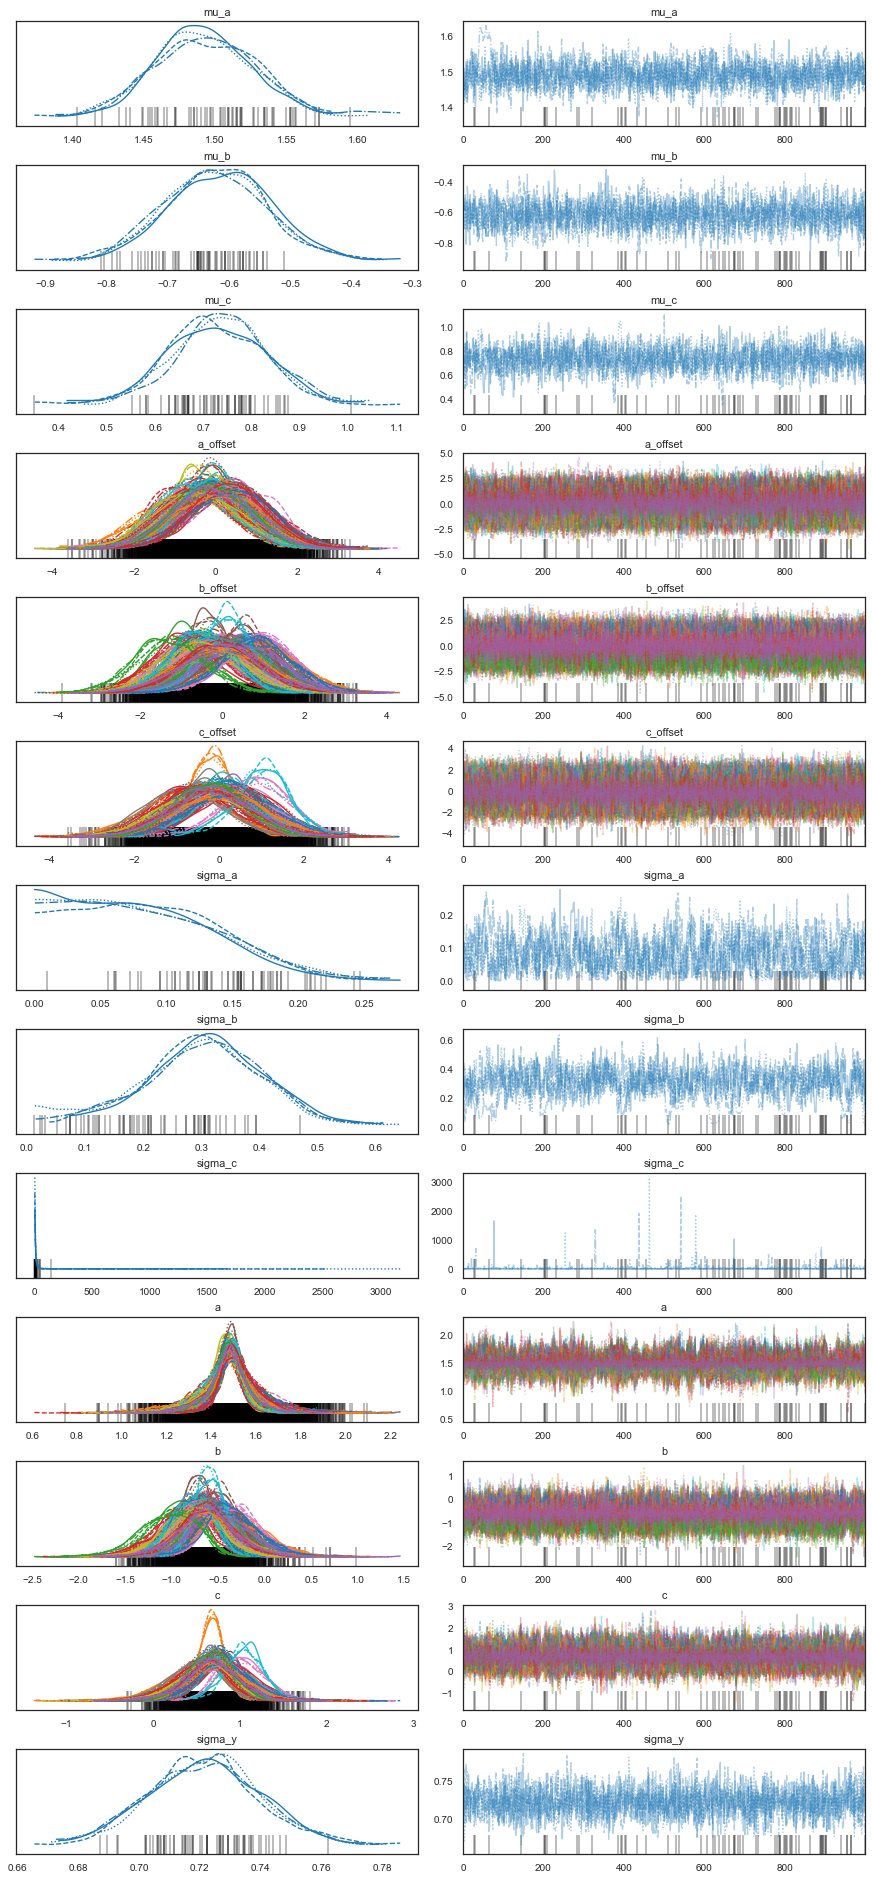

In [24]:
plot_trace(hierachical_trace)

0     -0.689048
1     -0.689048
2     -0.689048
3     -0.689048
4     -0.847313
         ...   
922   -0.090024
923   -0.090024
924   -0.090024
925    0.355287
926    0.355287
Name: Uppm, Length: 919, dtype: float64

<ipython-input-31-42822732a15e>:4: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
  forestplot(hierarchical_trace, var_names=['a'])
D:\Anaconda\envs\mypm3env\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

<Figure size 432x1008 with 0 Axes>

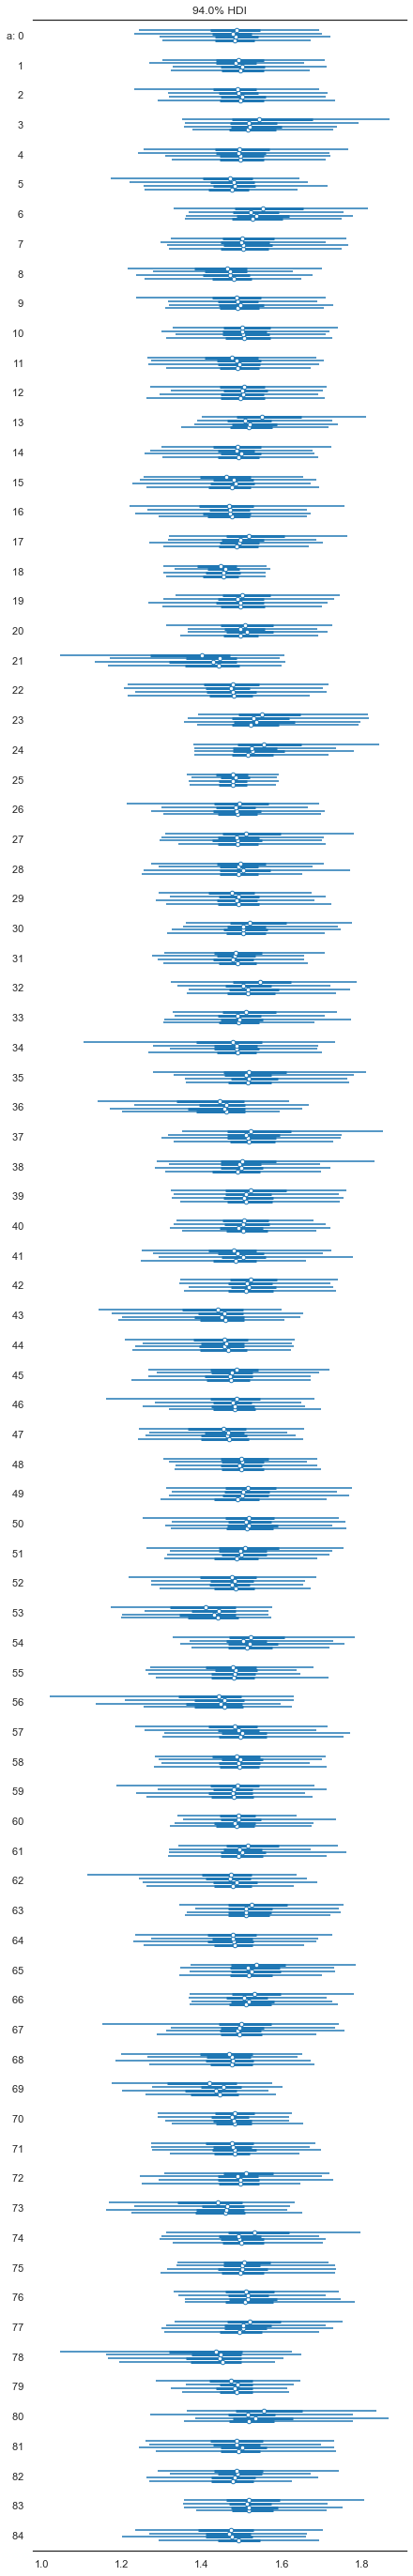

In [31]:
#Forest Plots can be quite useful in visualizing the posterior distributions across the clustering units.
from pymc3 import forestplot, traceplot, plot_posterior
plt.figure(figsize=(6,14))
forestplot(hierarchical_trace, var_names=['a'])

__Part 2: Bayesian Model Averaging__

Below you will find the BMA_Wine class. There are a couple of differences between it and the LDA/QDA class. First, you have to fit the model after you construct it (i.e. BMA = BMA_Wine(outcomevariable, datawithoutoutcomevariable); BMA_fit = BMA.fit()). Second, all output functions require handing it the true class values as well as the data you want to predict from. 

In [ ]:
from mpmath import mp
import numpy as np 
import pandas as pd 
import statsmodels.api as sm
from statsmodels.tools import add_constant
from itertools import combinations
mp.dps = 50

#This class is based on the BMA class provided by Bill Basener in: https://www.kaggle.com/billbasener/bayesian-model-averaging-logistic-regression
#It has been modified to allow for multinomial regression (logistic regression for more than 2 categories)
#Specifically, I've hardcoded the model as a 3 category multinomial regression, so this code doesn't generalize to any other model
class BMA_Wine:
    
    def __init__(self, y, X, **kwargs):
        # Setup the basic variables.
        self.y = y
        self.X = X
        self.names = list(X.columns)
        self.nRows, self.nCols = np.shape(X)
        self.likelihoods = mp.zeros(self.nCols,1)
        self.likelihoods_all = {}
        self.coefficients_mp = mp.zeros(self.nCols,2)
        self.coefficients = np.zeros((self.nCols, 2))
        self.probabilities = np.zeros(self.nCols)
        # Check the max model size. (Max number of predictor variables to use in a model.)
        # This can be used to reduce the runtime but not doing an exhaustive sampling.
        if 'MaxVars' in kwargs.keys():
            self.MaxVars = kwargs['MaxVars']
        else:
            self.MaxVars = self.nCols  
        # Prepare the priors if they are provided.
        # The priors are provided for the individual regressor variables.
        # The prior for a model is the product of the priors on the variables in the model.
        if 'Priors' in kwargs.keys():
            if np.size(kwargs['Priors']) == self.nCols:
                self.Priors = kwargs['Priors']
            else:
                print("WARNING: Provided priors error.  Using equal priors instead.")
                print("The priors should be a numpy array of length equal tot he number of regressor variables.")
                self.Priors = np.ones(self.nCols)  
        else:
            self.Priors = np.ones(self.nCols)  
        if 'Verbose' in kwargs.keys():
            self.Verbose = kwargs['Verbose'] 
        else:
            self.Verbose = False 
        if 'RegType' in kwargs.keys():
            self.RegType = kwargs['RegType'] 
        else:
            self.RegType = 'LS' 
        
    def fit(self):
        # Perform the Bayesian Model Averaging
        
        # Initialize the sum of the likelihoods for all the models to zero.  
        # This will be the 'normalization' denominator in Bayes Theorem.
        likelighood_sum = 0
        
        # To facilitate iterating through all possible models, we start by iterating thorugh
        # the number of elements in the model.  
        max_likelihood = 0
        for num_elements in range(1,self.MaxVars+1): 
            
            if self.Verbose == True:
                print("Computing BMA for models of size: ", num_elements)
            
            # Make a list of all index sets of models of this size.
            Models_current = list(combinations(list(range(self.nCols)), num_elements)) 
             
            # Occam's window - compute the candidate models to use for the next iteration
            # Models_previous: the set of models from the previous iteration that satisfy (likelihhod > max_likelihhod/20)
            # Models_next:     the set of candidate models for the next iteration
            # Models_current:  the set of models from Models_next that can be consturcted by adding one new variable
            #                    to a model from Models_previous
                                   
            
            # Iterate through all possible models of the given size.
            for model_index_set in Models_current:
                
                # Compute the linear regression for this given model. 
                model_X = self.X.iloc[:,list(model_index_set)]

                model_regr = sm.MNLogit(self.y, model_X).fit(disp=0)
                
                # Compute the likelihood (times the prior) for the model. 
                model_likelihood = mp.exp(-model_regr.bic/2)*np.prod(self.Priors[list(model_index_set)])
                
                if self.Verbose == True:
                    pass
                    #print("Model Variables:",model_index_set,"likelihood=",model_likelihood)
                self.likelihoods_all[str(model_index_set)] = model_likelihood
                
                # Add this likelihood to the running tally of likelihoods.
                likelighood_sum = mp.fadd(likelighood_sum, model_likelihood)
                # Add this likelihood (times the priors) to the running tally
                # of likelihoods for each variable in the model.
                for idx, i in zip(model_index_set, range(num_elements)):
                    self.likelihoods[idx] = mp.fadd(self.likelihoods[idx], model_likelihood, prec=2000)
                    for j in np.arange(model_regr.params.shape[1]):

                        self.coefficients_mp[idx,j] = mp.fadd(self.coefficients_mp[idx,j], model_regr.params[j][i]*model_likelihood, prec=2000)
                max_likelihood = np.max([max_likelihood,model_likelihood]) # get the new max likelihood if it is this model
                
                    

        # Divide by the denominator in Bayes theorem to normalize the probabilities 
        # sum to one.
        self.likelighood_sum = likelighood_sum
        for idx in range(self.nCols):
            self.probabilities[idx] = mp.fdiv(self.likelihoods[idx],likelighood_sum, prec=1000)
            for j in range(2):
                self.coefficients[idx,j] = mp.fdiv(self.coefficients_mp[idx,j],likelighood_sum, prec=1000)
        
        # Return the new BMA object as an output.
        return self
    
 
    def predict_MAP(self,true_class, data):
        data = np.asarray(data)
        result = np.zeros((data.shape[0],3))
        temp = sm.MNLogit(true_class, exog=np.asarray(data))
        result = temp.predict(params = self.coefficients, exog = np.asarray(data))
        result = pd.DataFrame(result, columns= ["A", "C", "F"])
        res_MAP = result.idxmax(axis=1)
        to_return = pd.DataFrame({'TrueClass':true_class, 'MAP':res_MAP})
        return to_return
    

    def misclass_rate(self, true_class, data):
        maps = self.predict_MAP(true_class, data)
        
        
        maps['Mis_class'] = maps['MAP']  == maps['TrueClass']
        
        mis_class =  1 - maps['Mis_class'].mean()
        
        return mis_class
    def misclass_xtabs(self, true_class, data):
        maps = self.predict_MAP(true_class, data)
        
        xtabs = pd.crosstab(maps['MAP'], maps['TrueClass'])        
        return xtabs
    
    def summary(self):
        # Return the BMA results as a data frame for easy viewing.
        df = pd.DataFrame([self.names, list(self.probabilities), list(self.coefficients)], 
             ["Variable Name", "Probability", "Avg. Coefficient"]).T
        return df  